# Implementation of MIDI to text encoding

As described in Payne, 2018 (http://www.christinemcleavey.com/files/clara-musical-lstm.pdf)

MIDI file will be encoded both in notewise format and chordwise format.

In [1]:
import argparse
import random
import os
import numpy as np
from math import floor
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note
import music21
from pathlib import Path

Given a file name we want to translate the corresponding MIDI track into chordwise and notewise encodings. Encodings will be adjusted to reflect the specified sampling rate, note range, and note offsets (offest here means a shift in pitch).

Loading the MIDI file using music21 library

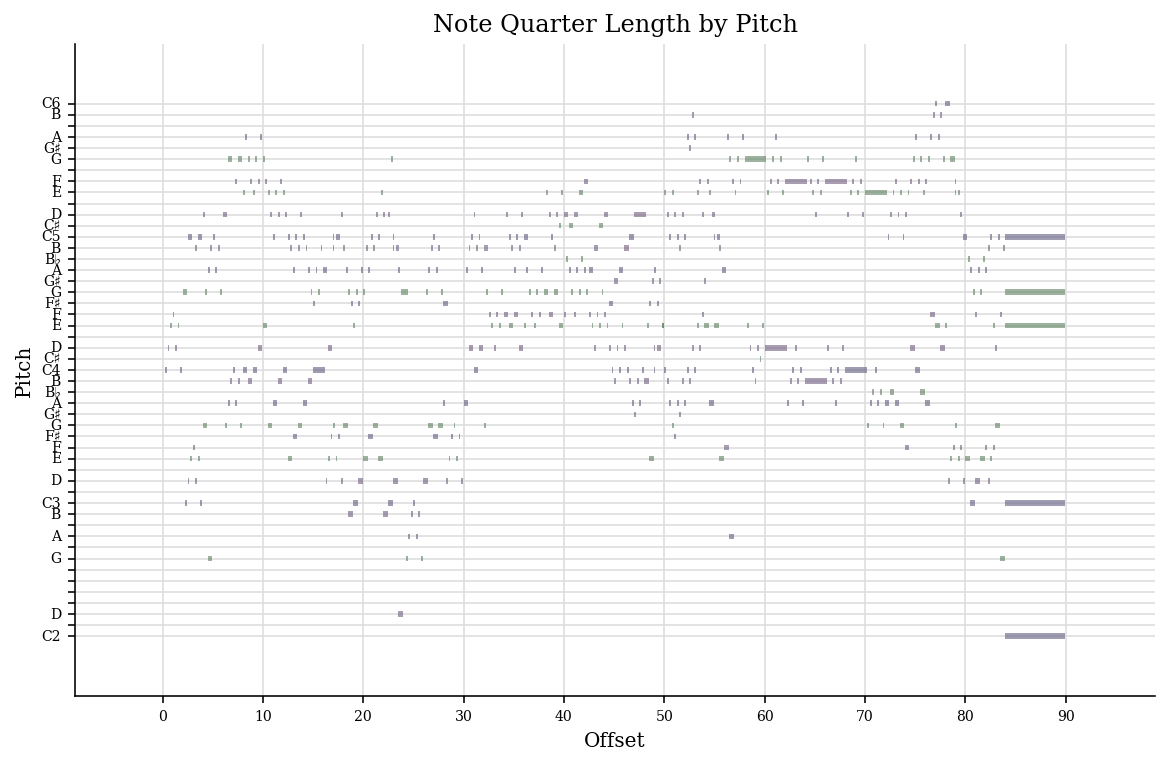

In [39]:
fname = "Bach_2PartInv_No1_in_C_BWV772.mid"
mf = music21.midi.MidiFile()

mf.open(fname)
mf.read()
mf.close()

midi_stream = music21.midi.translate.midiFileToStream(mf)
midi_stream.show("midi")
midi_stream.plot('pianoroll')

## Chordwise encoding

Create list of piano- and violin-like instruments which the model can be trained on.

In [3]:
VIOLINLIKE=["Violin", "Viola", "Cello", "Violincello", "Violoncello", "Flute", 
            "Oboe", "Clarinet", "Recorder", "Voice", "Piccolo",
            "StringInstrument", "Bassoon", "Horn"]

PIANOLIKE = ["Piano", "Harp", "Harpsichord", "Organ", ""]

Set up the parameters for the encoding

| Parameter | Description |
| :---: | :--- |
| note_range | Range of allowed pitches that the MIDI track will be limited to (reduced data and training time)|
| note_offset | Pitch offset used to center notes after note range reduction |
| sample_freq | Frequency the track should be sample with: track is sampled $val times per quarter note |
| chamber | Boolean value, indicates if piano and violin notes are used |
| num_instruments | Number of instruments we support for the encoding, two in this case for piano and violin |
| max_time_step | Number of timesteps we get when we sample the track with sample frequency |

In [4]:
sample_freq = 4
note_range = 38
note_offset = 45
chamber = False
numInstruments = 2 if chamber else 1
maxTimeStep = floor(midi_stream.duration.quarterLength * sample_freq) + 1

Initiate the array to hold the sampled score in vector format. The array denotes for each timestep the instrument that plays (redundant here, we only have one instrument) and the pitch it plays.

In [5]:
score_arr = np.zeros((maxTimeStep, numInstruments, note_range))

print(f"length of track, number of instruments, note range)")
print(score_arr.shape)

length of track, number of instruments, note range)
(361, 1, 38)


Create the class filters used for iterating over the note and chord (this is the chord used in music theory, not the encoding chord) events. Both are separate event types, therefore we need to filters.

In [6]:
noteFilter = music21.stream.filters.ClassFilter('Note')
chordFilter = music21.stream.filters.ClassFilter('Chord')

Initialize a list to hold the tuples of (pitch, offset, duration and instrument id).

In [7]:
notes = []

 Append the played notes from the note events as a tuple containing (pitch, offset, duration, instrument id) by iteratin over all note events. 
 
 The pitch will be adjusted by the note_offset, the offset (when the note begins to play) will be delayed by the sample frequency, since we have times sample frequency more time steps, and the note duration will be lengenthed as well by multiplying with the sample frequency. 

In [8]:
print(f"Structure of tuple in notes list:")
print(f"\t(pitch, offset, duration, instrument id)")

Structure of tuple in notes list:
	(pitch, offset, duration, instrument id)


In [9]:
for n in midi_stream.recurse().addFilter(noteFilter):
    
    if chamber:
        instr = n.activeSite.getInstrument()
        instrumentID = None
        
        # Determine if instrument is  in list piano-/violin-like
        if str(instr) in PIANOLIKE:
            instrumentID = 0
        elif str(instr) in VIOLINLIKE:
            instrumentID = 1
        else:
            print("Warning, unknown instrument: " + str(instr))
            instrumendID = -1
            
        if instrumentID == -1:
            print("This would return an empty array")
    
    notes.append(
        (n.pitch.midi - note_offset, 
         floor(n.offset * sample_freq), 
         floor(n.duration.quarterLength * sample_freq), 
        0) # 0 since only one instrument
    )

In [10]:
print(f"Number of notes from note events: {len(notes)}")

Number of notes from note events: 467


Iterate over all chord events in MIDI stream and append the played chords to the notes list. Tuple format is the same as for the note events.

In [11]:
for c in midi_stream.recurse().addFilter(chordFilter):
    
    # Get pitches for each chord element
    pitchesInChord = c.pitches

    if chamber:
        instr = n.activeSite.getInstrument()
        instrumentID = None
        
        # Determine if instrument is in list piano-/violin-like
        if str(instr) in PIANOLIKE:
            instrumentID = 0
        elif str(instr) in VIOLINLIKE:
            instrumentID = 1
        else:
            print("Warning, unknown instrument: " + str(instr))
            instrumendID = -1
        
        if instrumentID == -1:
            print("This would return an empty array")
    
    for p in pitchesInChord:
        notes.append(
            (p.midi - note_offset, 
             floor(c.offset * sample_freq), 
             floor(c.duration.quarterLength * sample_freq), 
             0) # 0 since only one instrument
        )

In [12]:
print(f"Number of notes from note and chord events: {len(notes)}")

Number of notes from note and chord events: 472


Fill the score array. 

A 1 or 2 denotes the pitch that is played by an isntrument at a timestep. Before writing the valies to the score array, make sure the pitch values are inside the note range by shifting values up or down an octave depending on their current value.

| char | description |
| :---: | :--- |
| 1 | Note begins |
| 2 | Note continues | 

In [13]:
for note in notes:
    
    pitch = note[0]
    offset = note[1]
    duration = note[2]
    instr_id = note[3]
    
    # If pitch became negative after subtracting 
    # the note offset: shift up one octave
    while pitch < 0:
        pitch += 12

    # If pitch is outside of note range, shift down by
    # an octave until it is inside the range
    while pitch >= note_range:
        pitch -= 12

    # Remember: 
    # score_arr dims (timestep, instrument id, pitch)
    # Write 1 for when a note is struck
    score_arr[offset, instr_id, pitch] = 1                  
    
    # Write 2 for when a note continues after being struck
    note_start = offset + 1
    note_end = offset + duration
    score_arr[note_start:note_end, instr_id, pitch] = 2


An element in the score array looks like this:

In [14]:
score_arr[10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

Convert information from score array to chordwise encoded strings. This is done by appending the correspondin instrument identifier (p or v) and iterating over each timestep for each instrument in the array.

In the encoded string a played note is similiarily indicated with a 1, a continued note with 2, and a silent note with 0.

In [15]:
instr = {}
instr[0] = "p" # piano
instr[1] = "v" # violin

chordwise_strings=[]

for timestep in score_arr:
    
    # start with violin first
    for i in list(reversed(range(len(timestep)))):
        chordwise_string = [str(int(note)) for note in timestep[i]]
        chordwise_strings.append(instr[i] + ''.join(chordwise_string))      

In [16]:
for i, chord in enumerate(chordwise_strings):
    print(chord)
    if i == 4: break

p00000000000000000000000000000000000000
p00000000000000010000000000000000000000
p00000000000000000100000000000000000000
p00000000000000000001000000000000000000
p00000000000000000000100000000000000000


Now we augment the data: to teach the model that the musical structures found in the dataset work in all pitches, not just the one found in each track, we transpose each track to cover a full octave in modulations.

In [17]:
modulated = []

# Get highest note in range
note_range = len(chordwise_strings[0]) - 1

# Iterate over octave range to add all possible modulations
for i in range(0,12):

    for chord in chordwise_strings:
        
        # Preppend and append 6 zeros to chord tones
        # Excludes the instrument signifier
        padded = '000000' + chord[1:] + '000000'
        
        # Build modulated string, consists of:
        ## instrumend signifier and chord padded corresponding to current modulation
        modulated.append(chord[0] + padded[i:i + note_range])

In [18]:
print(f"Length of score: {len(chordwise_strings)}")
print(f"Length of modulated score: {len(modulated)}")

Length of score: 361
Length of modulated score: 4332


In [19]:
print(f"First five timesteps in the track:")
for i, chord in enumerate(chordwise_strings):
    print(chord)
    if i == 5: break

First five timesteps in the track:
p00000000000000000000000000000000000000
p00000000000000010000000000000000000000
p00000000000000000100000000000000000000
p00000000000000000001000000000000000000
p00000000000000000000100000000000000000
p00000000000000000100000000000000000000


In [20]:
print(f"First five timesteps after modulation:")
for i, chord in enumerate(modulated):
    print(chord)
    if i == 5: break

First five timesteps after modulation:
p00000000000000000000000000000000000000
p00000000000000000000010000000000000000
p00000000000000000000000100000000000000
p00000000000000000000000001000000000000
p00000000000000000000000000100000000000
p00000000000000000000000100000000000000


## Notewise encoding

After encoding the MIDI track chordwise we can use the generated strings to create the notewise encoding. 

The notewise encoded string is generated from each chordwise timestep.

To that end we iterate over all chordwise encoded strings, find, if it exists, the next chord for the instrument the chord belongs to, and append the notewise tokens to the notewise_list.

The start of a note is encoded as `p{pitch}`,
the end as `endp{pitch}` and the end of a timestep as `wait`.

If a note is held, there will be no token for that note. The idea is, that the note will be played until we encounter the `endp` token

In [21]:
notewise_strings = []

for chord_index, chord in enumerate(chordwise_strings):

    # Find next chord for the instrument
    next_chord = ""
    for k in range(chord_index + 1, len(chordwise_strings)):
        if chordwise_strings[k][0] == chord[0]:
            next_chord = chordwise_strings[k]
            break

    instr_prefix = chord[0]
    chord = chord[1:]
    next_chord = next_chord[1:]
    
    for i in range(len(chord)):
        
        # Skip if no note is played
        if chord[i] == "0":
            continue
            
        # str(i) is the pitch (the position in the chord)
        note = instr_prefix + str(i) 
        
        if chord[i] == "1":
            notewise_strings.append(note)
            
        # If chord[i]=="2" note is held
        # until we encounter 0 (note not played)
        #
        ## a held note is portrayed by a 'wait', since 'wait'
        ## denotes a time step
        if next_chord == "" or next_chord[i] == "0":      
            notewise_strings.append("end" + note)

    if instr_prefix == "p":
        notewise_strings.append("wait")


In [22]:
print("Here we see the first four timesteps in notewise encoding:\n")
for i, note in enumerate(notewise_strings):
    print(note)
    if i == 9: break

Here we see the first four timesteps in notewise encoding:

wait
p15
endp15
wait
p17
endp17
wait
p19
endp19
wait


Our vocabular of notewise tokens has a size of 63.

In [23]:
unique_tokens = len(set(notewise_strings))
unique_tokens

63

The percentage of tokens in this track that are `wait` tokens if roughly 30%:

In [24]:
counter = 0
for token in notewise_strings:
    if token == "wait":
        counter += 1
percentage_waits = (counter * 100)/len(notewise_strings)
percentage_waits

28.04972804972805

Since `waits` are so common, we need to make sure that the model not only predicts `waits`. With the token ocurring to often, this might happen quite easily since the model ist right 30% of the time when predicting a `wait` - this is a local minimum that we do not want the model to get stuck in.

To avoid that the `wait` tokens are consolidated. Consecutive `wait` tokens are merged and the number of token that followed indicated with an interger number appended to the `wait` token:
i.e. `wait4`. Single `wait` tokens will be indicated with `wait1`.

In [25]:
i = 0
translated_string = ""

while i < len(notewise_strings):
    
    wait_count = 1    
    if notewise_strings[i] == 'wait':
        
        # count the consecutive waits
        while (
            wait_count <= sample_freq * 2                 # max time steps allowed to pass without changing  
                                                          # anything = one half note (see below)
            and i + wait_count < len(notewise_strings)     # check for out of bounds
            and notewise_strings[i + wait_count] == 'wait' # is next one wait?
        ):
            wait_count += 1
            
        notewise_strings[i] = 'wait' + str(wait_count)
        
    translated_string += notewise_strings[i] + " "    
    i += wait_count

In [26]:
print("The first four timesteps after consolidating waits:\n")
for i, note in enumerate(translated_string.split(" ")):
    print(note)
    if i == 9: break

The first four timesteps after consolidating waits:

wait1
p15
endp15
wait1
p17
endp17
wait1
p19
endp19
wait1


## Remove note durration in chordwise

Encoding held notes in the chordwise notation adds to many tokens to the vocab and the modell does not learn well when to hold a note. Since melodies are still recognizable even without note duration, we simply remove the `2`s from the chordwise encoded strings and replace them with `0`s. 

In [27]:
chordwise_string_with_duration = chordwise_strings.copy()
for i, chord in enumerate(chordwise_string_with_duration):
    chordwise_strings[i] = chord.replace("2", "0")

In [28]:
print(f"{chordwise_string_with_duration[9]}")
print(f"{chordwise_strings[9]}")

p00010000000000000000002000000000000000
p00010000000000000000000000000000000000


## Modify rests in chords

Since ~20% of all timesteps are silent, meaning no notes are played, it is very easy for the model to fall into a local minimum and only predict rests. To avoid this we encode each rest differently depending of the number of notes played in the previous 10 timesteps. To predict a rest the model is now forced to learn the structure that comes before a rest.

The number of notes from the previous 10 timesteps will be used to access a char from an alphabet string. 

Assuming two notes have been played in the last 10 timesteps, the rest would change to: `pbbbbbbbbbbbbbbbbbbb` with the char repeated as many times as the note range is long.

In [29]:
single_rest = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
noterange = len(chordwise_strings[0]) - 1
consolidated_chordwise_strings = chordwise_strings.copy()

i = 0
while i < len(chordwise_strings):
    
    j = 1
    
    if chordwise_strings[i][1:] == "0" * noterange:
        
        num_prev_notes = 0
        
        for j in range(-10, 0):
            
            if i + j >= 0:
                
                if chordwise_strings[i + j] == "":
                    continue
                    
                for c in chordwise_strings[i + j][1:]:
                    
                    if c == "1":
                        num_prev_notes += 1
                        
        num_prev_notes = min(num_prev_notes, len(single_rest) - 1)
        
        consolidated_chordwise_strings[i] = chordwise_strings[i][0] + single_rest[num_prev_notes] * noterange
        
    i = i + 1

In [30]:
chordwise_strings[:2]

['p00000000000000000000000000000000000000',
 'p00000000000000010000000000000000000000']

In [31]:
consolidated_chordwise_strings[:2]

['paaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'p00000000000000010000000000000000000000']

## Decoding

To demonstrate the decoding process, we will decode the previously encoded MIDI track.

### Chordwise decoding

In [32]:
def decode_chordwise_strings(score, sample_freq, note_offset):

    speed = 1. / sample_freq
    piano_notes = []
    violin_notes = []
    time_offset = 0
    
    for i in range(len(score)):
        
        current_chord = score[i]
        
        # no note is played
        if len(current_chord) == 0:
            print("chord len is 0, no note played, continue")
            continue

        # skip instrument identifier
        for j in range(1, len(current_chord)):
            
            # a note is being played
            if current_chord[j] == "1":
                
                duration = 2  # why 2 ???
                new_note = music21.note.Note(j + note_offset)    
                new_note.duration = music21.duration.Duration(duration * speed)
                new_note.offset = (i + time_offset) * speed
                
#                 print(f"Chord #{i}: {new_note.name} duration: {new_note.duration} offset: {new_note.offset}")
                
                if current_chord[0] == 'p':
                    piano_notes.append(new_note)
                
                elif current_chord[0] == 'v':
                    violin_notes.append(new_note)
    
    violin = music21.instrument.fromString("Violin")
    piano = music21.instrument.fromString("Piano")
    
    violin_notes.insert(0, violin)
    piano_notes.insert(0, piano)
    
    violin_stream = music21.stream.Stream(violin_notes)
    piano_stream = music21.stream.Stream(piano_notes)
    
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return main_stream

In [33]:
decoded_chords = decode_chordwise_strings(
    consolidated_chordwise_strings, 
    sample_freq, 
    note_offset
)

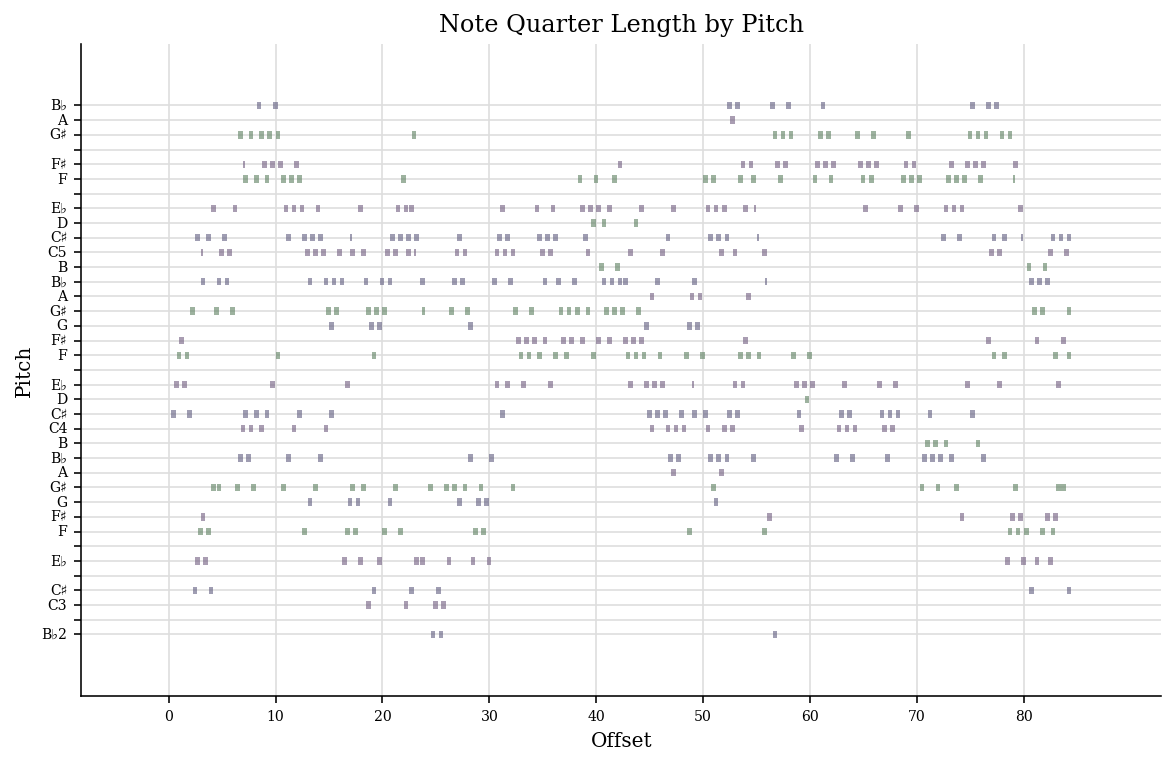

In [34]:
# write decoded chords to disk and then reload to able to play file
# just calling 
# string_2_chords.show("midi")
# does not work, plays, but without audible sound
decoded_chords_file = decoded_chords.write('midi', 'decoded_chords.mid')

mf = music21.midi.MidiFile()
mf.open("decoded_chords.mid")
mf.read()
mf.close()
chords_stream = music21.midi.translate.midiFileToStream(mf)

chords_stream.show("midi")
chords_stream.plot("pianoroll")

## Notewise decoding

In [35]:
def decode_notewise_strings(score, sample_freq, note_offset):
    
    speed = 1./sample_freq
    piano_notes = []
    violin_notes = []
    time_offset = 0
    
    i = 0
    while i < len(score):
        
        if score[i][:9] == "p_octave_":
            
            add_wait = ""
            
            if score[i][-3:] == "eoc":
                add_wait = "eoc"
                score[i] = score[i][:-3]
                
            this_note = score[i][9:]
            score[i] = "p" + this_note
            score.insert(i + 1, "p" + str(int(this_note) + 12) + add_wait)
            i += 1
            
        i += 1
        
    for i in range(len(score)):
        
        if score[i] in ["", " ", "<eos>", "<unk>"]:
            continue
        
        elif score[i][:3] == "end":
            
            if score[i][-3:] == "eoc":
                time_offset += 1
            continue
        
        elif score[i][:4] == "wait":
            time_offset += int(score[i][4:])
            continue
        
        else:
            # Look ahead to see if an end<noteid> was generated
            # soon after.  
            duration = 1
            has_end = False
            note_string_len = len(score[i])
            
            for j in range(1,200):
                
                if i + j == len(score):
                    break
                
                if score[i + j][:4] ==" wait":
                    duration += int(score[i + j][4:])
                
                if score[i + j][:3 + note_string_len] == "end" + score[i] or score[i + j][:note_string_len] == score[i]:
                    has_end = True
                    break
                
                if score[i + j][-3:] == "eoc":
                    duration += 1

            if not has_end:
                duration = 12

            add_wait = 0
            
            if score[i][-3:] == "eoc":
                score[i] = score[i][:-3]
                add_wait = 1

            try: 
                new_note = music21.note.Note(int(score[i][1:]) + note_offset)    
                new_note.duration = music21.duration.Duration(duration * speed)
                new_note.offset = time_offset * speed
                
                if score[i][0] == "v":
                    violin_notes.append(new_note)
                    
                else:
                    piano_notes.append(new_note)
                    
            except:
                print("Unknown note: " + score[i])           
            
            time_offset += add_wait
                
    violin = music21.instrument.fromString("Violin")
    piano = music21.instrument.fromString("Piano")
    
    violin_notes.insert(0, violin)
    piano_notes.insert(0, piano)
    
    violin_stream = music21.stream.Stream(violin_notes)
    piano_stream = music21.stream.Stream(piano_notes)
    
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return main_stream

In [36]:
decoded_notes = decode_notewise_strings(
    translated_string.split(" "), 
    sample_freq, 
    note_offset
)

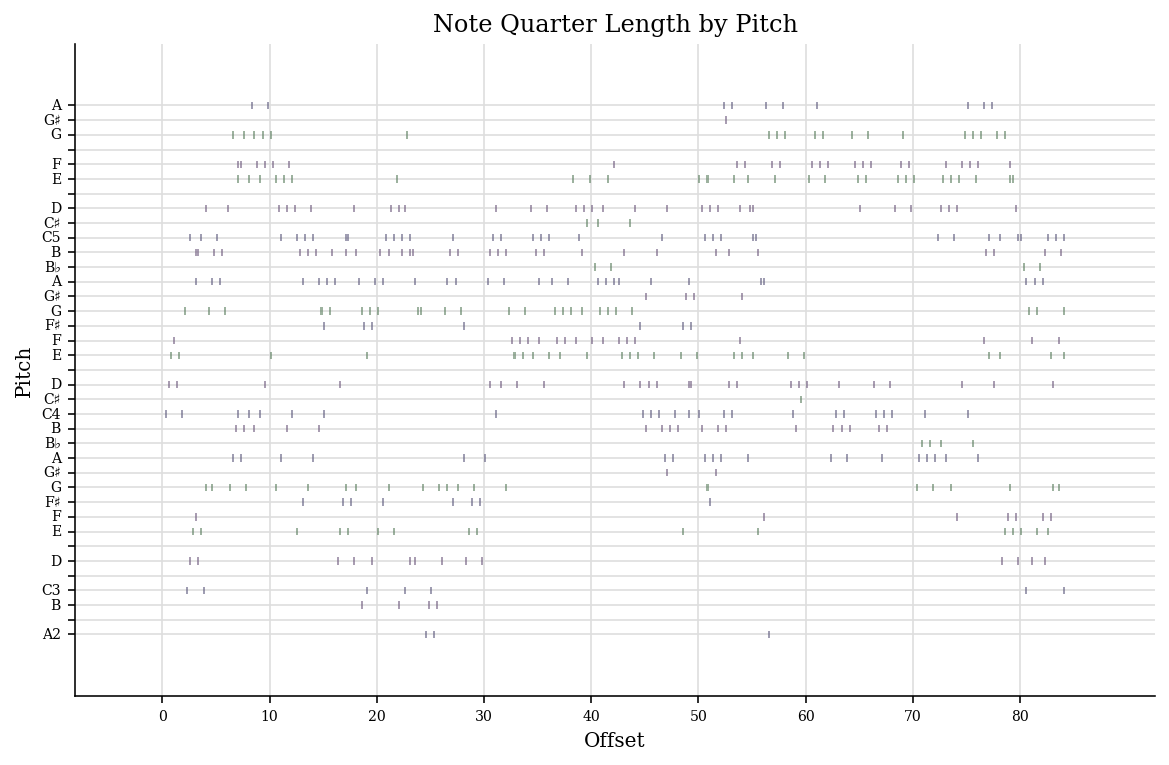

In [38]:
# write decoded notes to disk and then reload to able to play file
# just calling 
# string_2_notes.show("midi")
# does not work, plays, but without audible sound
decoded_notes_file = decoded_notes.write('midi', 'decoded_notes.mid')

mf = music21.midi.MidiFile()
mf.open("/media/fyyree/data/Documents/Studium/fp_b/notebooks/midi2text/decoded_notes.mid")
mf.read()
mf.close()
notes_stream = music21.midi.translate.midiFileToStream(mf)
notes_stream.show("midi")
notes_stream.plot("pianoroll")
